# Gold Distribution Estimation using Kriging Method with Geostatspy
**Presented at Python Conference Indonesia 2020**
<br />
## Kriging and Variogram Overview
Kriging is a geostatistical method used to estimate the value of a point as a linear combination of sample values around the point.
<br /> 
<br />
<img src="image/kriging.png" width=200 height=200 /> 
<br />
<img src="image/equation.png" width=250 height=250 />
<br/>
**Kriging weight (Wi)** is obtained from the minimum variance estimation by expanding the use of variogram.</br>
**Variogram** is a geostatistical method that can visualize variance trend on spatial (lag from one data to another). Variogram plot consisting of **data point (black point)** and **modelled  variogram (black line)**. 
<img src="image/vario.png" width=300 height=200 />
**Find the best possible model which fit close enough with experimental variogram** in order to get the optimum kriging weight

## Data Conditioning

In [1]:
import pandas as pd

df=pd.read_csv('pyconid.csv')

x=df.XCOO
y=df.YCOO
z=df.Au

df.head()

,ID,XCOO,YCOO,Au
0,2,770025,7680000,0.186
1,3,498651,7670000,0.156
2,4,795152,7570000,0.376
3,5,437050,7860000,0.025
4,6,752106,7630000,0.860


## Data Plotting

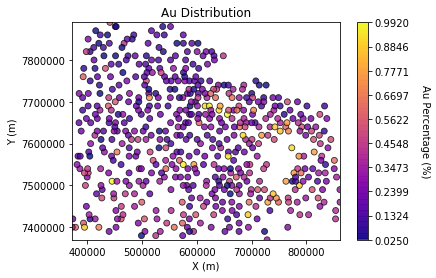

In [5]:
import geostatspy.GSLIB as gslib
import matplotlib.pyplot as plt
plt.close('all')

plt.figure()
cmap = plt.cm.plasma                                    # set the color map
gslib.locmap_st(df,'XCOO','YCOO','Au',
                min(x),max(x),min(y),max(y),min(z),max(z),
                'Au Distribution','X (m)','Y (m)','Au Percentage (%)',cmap)
plt.show()

## Variogram Plotting and Modeling

 x,y,z offsets = 0.0,5000.0


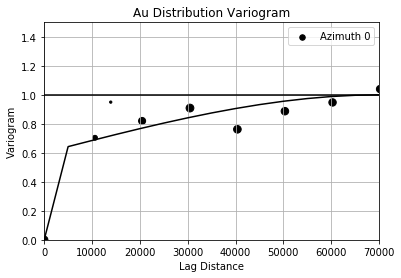

In [6]:
import geostatspy.geostats as geostats

lag=5000
lag_tol=1500
nlag=15
azi=0
azi_tol=0
bandwidth=9999
lags, gammas, npps = geostats.gamv(df,"XCOO","YCOO","Au",-9999,9999,
                                   lag,lag_tol,nlag,azi,azi_tol,
                                   bandwidth,isill=1.0)

#variogram modelling
nug = 0.6
nst = 2
it1 = 1; cc1 = 0.4; azi1 = azi; hmaj1 = 70000; hmin1 = 70000
#it is the type of variogram (Spherical, exponential, gaussian)
#assumption no contribution on minor structure
it2 = 1; cc2 = 0; azi2 = 0; hmaj2 = 9999.9; hmin2 = 400  
xlag=5000
vario = gslib.make_variogram(nug,nst,it1,cc1,azi1,
                             hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) 

# make model object
index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azi,vario) 

# plot variogram
plt.figure()                                  
plt.scatter(lags,gammas,color ='black',s =npps*0.1,label ='Azimuth '+str(azi))
plt.plot(h_maj,gam_maj,color = 'black')
plt.legend()
plt.plot([0,70000],[1.0,1.0],color = 'black')
# plt.plot([0,max(lags)],[1.0,1.0],color = 'black')
plt.xlabel('Lag Distance')
plt.ylabel('Variogram')
plt.title('Au Distribution Variogram')
plt.xlim([0,70000]); plt.ylim([0,1.5])
# plt.xlim([0,max(lags)]); plt.ylim([0,1.5])
plt.grid()
plt.show()

From the variogram plot, it can be seen that modelled variogram is very close to experimental variogram.
Therefore we can proceed to the next step (Variogram Map). This step is intended to see the anisotropy effect / azimuth angle trend.

## Variogram Map Overview
- **Variogram Map** is the projection of the experimental variogram plot in a 2D plane (X & Y coordinates)

- Used to **visualize the spatial continuity of data** in general

- The trend seen from the variogram map can be used to determine azimuth angle* in the variogram plot
<img src="image/variomap.png" width=300 height=300 />
<br/>
Azimuth angle* = Angle direction to plot data in variogram

## Variogram Map

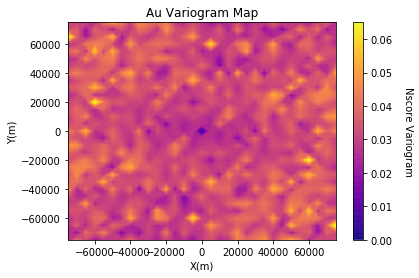

In [8]:
vmap2, npmap = geostats.varmapv(df,'XCOO','YCOO','Au',tmin=-9999.9,tmax=9999.9,
                               nxlag=15,nylag=15,dxlag=5000,dylag=10000,
                               minnp=1,isill=1)


plt.figure()
gridvar = 75005/15
gslib.pixelplt_st(vmap2,-75005,75005,-75005,75005,gridvar,0,0.065,
                  'Au Variogram Map','X(m)','Y(m)','Nscore Variogram',cmap)

plt.show()

- Variogram Map has no direction trend
- Azimuth angle selection is not significant
- No need to resample data on variogram plot


## Kriging

  Estimated   230400 blocks 
      average   0.3019484752403557  variance  0.01357532126830166


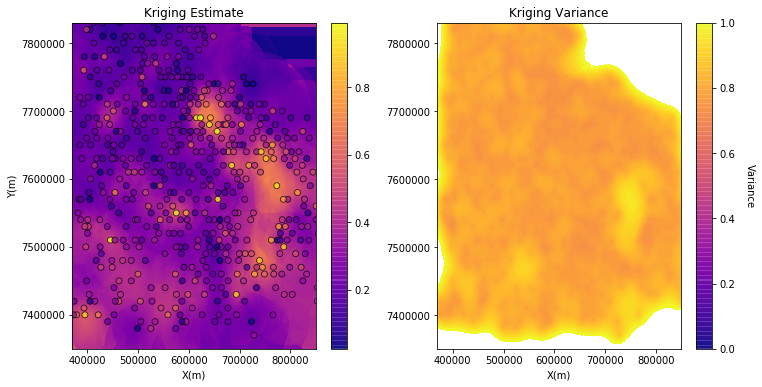

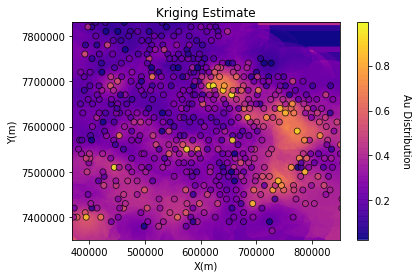

In [12]:
# kriging using ordinary kriging

tmin = 0; tmax = 999
nxdis = 1; nydis = 1    # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10   # minimum and maximum data for kriging 
nx = 480; ny = 480      # number of cells
xsiz=1000;ysiz=1000    # cell size
xmn = 370100; ymn = 7350100       # grid origin, location center of lower left cell

radius = 75000            # maximum search distance
ktype = 1               # 0 for simple kriging, 1 for ordinary kriging
skmean = 67.3;      # simple kriging mean (used if simple kriging is selected)


kmap,vmap = geostats.kb2d(df, 'XCOO', 'YCOO', 'Au', tmin, tmax, nx, xmn, 
                          xsiz, ny, ymn, ysiz, nxdis, nydis, ndmin, ndmax, 
                          radius, ktype, skmean, vario)

xmin=370000;xmax=xmin+(xsiz*nx)
ymin=7350000; ymax=ymin+(ysiz*ny)

plt.figure(figsize = (12,6))

plt.subplot(121)
gslib.locpix_st(kmap,xmin,xmax,ymin,ymax,xsiz,min(z),max(z),df,'XCOO','YCOO','Au','Kriging Estimate','X(m)','Y(m)','',cmap)

plt.subplot(122)
gslib.pixelplt_st(vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','','Variance',cmap)

plt.show()

plt.figure()
gslib.locpix_st(kmap,xmin,xmax,ymin,ymax,xsiz,min(z),max(z),df,
                'XCOO','YCOO','Au','Kriging Estimate','X(m)','Y(m)',
                'Au Distribution',cmap)
plt.show()

## Sequential Gaussian Simulation (SGS) Overview
By performing kriging, every unobserved point has its own estimated value and variance.
<br />
Based on the results of its data distribution, SGS (Sequential Gaussian Simulation) conducted a random simulation to determine the values that still within the distribution range
<img src="image/sgs.png" width=650 height=300 />

## SGS


 Data for SGSIM: Number of acceptable data     = 551
                 Number trimmed                = 0
                 Weighted Average              = 0.3026
                 Weighted Variance             = 0.037
                 Weighted Transformed Average  = 0.0235
                 Weighted Transformed Variance = 0.9133
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 10000
   currently on node 20000
   currently on node 30000
   currently on node 40000
   currently on node 50000
   currently on node 60000
   currently on node 70000
   currently on node 80000
   currently on node 90000
   currently on node 100000
   currently on node 110000
   currently on node 120000
   currently on node 130000
   currently on node 140000
   currently on node 150000
   currently on node 160000
   currently on node 170000
   currently on node 180000
   currently on node 190000
   currently on node 200000
   currently

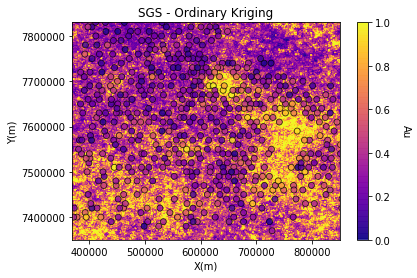

In [14]:
#SGS for ordinary kriging
sim_ok = geostats.sgsim(df,'XCOO','YCOO','Au',wcol=-1,scol=-1,
                    tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1.0,ltail=1,ltpar=0.0,utail=1,utpar=0.3,
            nsim=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
            radius=radius,radius1=1,sang1=0,mxctx=10,mxcty=10,ktype=1,
            colocorr=0.0,sec_map=0,vario=vario)

plt.figure()
gslib.locpix_st(sim_ok,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df
                ,'XCOO','YCOO','Au','SGS - Ordinary Kriging',
                'X(m)','Y(m)','Au',cmap)
plt.show()

## Conclusions
- Geostatspy is a complete python library for geostatistics (kriging) from A-Z
- Variogram is a main parameter that determines the results of kriging estimation
- Variogram map is an effective way to determine data trend, apart from qualitative analysis in the field
- Besides being able to model the estimated value, kriging can also model the uncertainty by conducting SGS


## References
Li C, Hancock CM, Hamm NAS, Veettil SV, You C. Analysis of the Relationship between Scintillation Parameters, Multipath and ROTI. Sensors. 2020. 20(10):2877. 10.3390/s20102877
<br />
Molayemat, Hossein & Torab, Farhad. (2017). Evaluation of coalbed methane potential in Parvadeh IV coal deposit in central Iran using a combination of MARS modeling and Kriging. Journal of Mining & Environment. 8. 305-319. 10.22044/jme.2017.874. 
<br />
Abraham AB, Evans AB, Thompson BE. Analysis of Spatial Distribution Pattern of Reservoir Petrophysical Properties for Horizontal Well Performance Evaluation-A Case Study of Reservoir X. The Open Petroleum Engineering Journal. 2019. 12. 10.2174/1874834101912010001
<br />
Reimann, C., Äyräs, M., Chekushin, V., Bogatyrev, I., Boyd, R., Caritat, P. de, Dutter, R., Finne, T.E., Halleraker, J.H., Jæger, Ø., Kashulina, G., Lehto, O., Niskavaara, H., Pavlov, V., Räisänen, M.L., Strand, T. and Volden, T., 1998. Environmental Geochemical Atlas of the Central Barents Region. ISBN 82-7385-176-1. NGU-GTK-CKE Special Publication, Geological Survey of Norway, Trondheim, Norway, 745 pp
<br />
https://github.com/GeostatsGuy/GeostatsPy